In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from UNET_model import UNET
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from torchinfo import summary
from torchvision.transforms.functional import rgb_to_grayscale

In [2]:
EPOCH_NUM = 300
BATCH_SIZE = 32
LR = 0.001
is_grayscale = True

In [3]:
imgs_before = []
imgs_after = []
acts = []

In [4]:
for i in range(10):
    img_before= torch.load(f'data/imgs_before_unet_{i}.pt')
    img_after= torch.load(f'data/imgs_after_unet_{i}.pt')
    act = torch.load(f'data/actions_unet_{i}.pt')
    imgs_before.append(img_before)
    imgs_after.append(img_after)
    acts.append(act)
    print(f'loaded {i}')
imgs_before = torch.cat(imgs_before, 0)
imgs_before = imgs_before.float() / 255.0
imgs_before = rgb_to_grayscale(imgs_before) if is_grayscale else imgs_before
imgs_after = torch.cat(imgs_after, 0)
imgs_after = imgs_after.float() / 255.0
imgs_after = rgb_to_grayscale(imgs_after) if is_grayscale else imgs_after
acts = torch.cat(acts, 0)
acts = F.one_hot(acts.long(), 4)


loaded 0
loaded 1
loaded 2
loaded 3
loaded 4
loaded 5
loaded 6
loaded 7
loaded 8
loaded 9


In [5]:

test_size = int(imgs_before.size(0) * 0.1)
val_size = int(imgs_before.size(0) * 0.1)
train_size = imgs_before.size(0) - test_size - val_size

train_imgs_before = imgs_before[:train_size]
train_imgs_after = imgs_after[:train_size]
train_acts = acts[:train_size]

val_imgs_before = imgs_before[train_size:train_size + val_size]
val_imgs_after = imgs_after[train_size:train_size + val_size]
val_acts = acts[train_size:train_size + val_size]

test_imgs_before = imgs_before[train_size + val_size:]
test_imgs_after = imgs_after[train_size + val_size:]
test_acts = acts[train_size + val_size:]

batch_count =  np.ceil(train_imgs_before.size(0) / BATCH_SIZE).astype(int)

unet = UNET(is_grayscale)
summary(unet, input_size=[(BATCH_SIZE, 1, 128, 128), (BATCH_SIZE, 4)] if is_grayscale else [(BATCH_SIZE, 3, 128, 128), (BATCH_SIZE, 4)])

/home/afg/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Layer (type:depth-idx)                   Output Shape              Param #
UNET                                     [32, 1, 128, 128]         --
├─Conv2d: 1-1                            [32, 64, 128, 128]        640
├─BatchNorm2d: 1-2                       [32, 64, 128, 128]        128
├─Conv2d: 1-3                            [32, 64, 128, 128]        36,928
├─BatchNorm2d: 1-4                       [32, 64, 128, 128]        128
├─Conv2d: 1-5                            [32, 64, 128, 128]        128
├─BatchNorm2d: 1-6                       [32, 64, 128, 128]        128
├─MaxPool2d: 1-7                         [32, 64, 64, 64]          --
├─Conv2d: 1-8                            [32, 128, 64, 64]         73,856
├─BatchNorm2d: 1-9                       [32, 128, 64, 64]         256
├─Conv2d: 1-10                           [32, 128, 64, 64]         147,584
├─BatchNorm2d: 1-11                      [32, 128, 64, 64]         256
├─Conv2d: 1-12                           [32, 128, 64, 64]       

In [6]:
def display_epoch(epoch):
    unet.load_state_dict(torch.load(f'unet_gray_mse_scheduler_batchsize16/unet_epoch_{epoch}.pth'))
    with torch.no_grad():
        unet_output = unet(test_imgs_before, test_acts)
        fig, axes = plt.subplots(10, 3, figsize=(6, 15))
        for i in range(10):
            axes[i][0].imshow((test_imgs_before[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8), cmap="gray" if is_grayscale else None)
            axes[i][1].imshow((unet_output[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8), cmap="gray" if is_grayscale else None)
            axes[i][2].imshow((test_imgs_after[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8), cmap="gray" if is_grayscale else None)
            axes[i][0].axis('off')
            axes[i][1].axis('off')
            axes[i][2].axis('off')
        plt.savefig("unet_test.png")
        nn.functional.mse_loss(unet_output, test_imgs_after)
        print(f'mse: {nn.functional.mse_loss(unet_output, test_imgs_after)}')

mse: 0.00047754362458363175


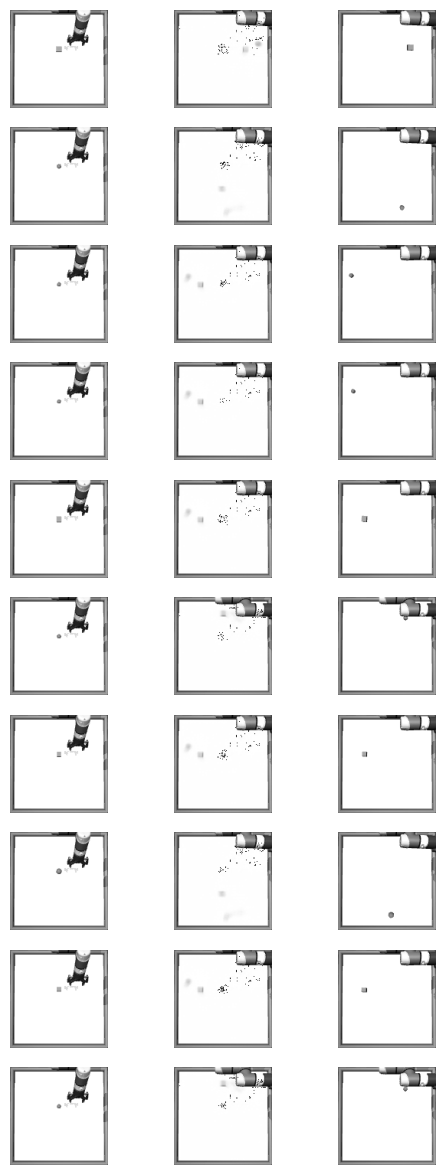

In [7]:
unet.load_state_dict(torch.load('unet_gray_mse_scheduler_batchsize16/unet.pth'))
with torch.no_grad():
    unet_output = unet(test_imgs_before, test_acts)
    fig, axes = plt.subplots(10, 3, figsize=(6, 15))
    for i in range(10):
        axes[i][0].imshow((test_imgs_before[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8), cmap="gray" if is_grayscale else None)
        axes[i][1].imshow((unet_output[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8), cmap="gray" if is_grayscale else None)
        axes[i][2].imshow((test_imgs_after[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8), cmap="gray" if is_grayscale else None)
        axes[i][0].axis('off')
        axes[i][1].axis('off')
        axes[i][2].axis('off')
    plt.savefig("unet_test.png")
    nn.functional.mse_loss(unet_output, test_imgs_after)
    print(f'mse: {nn.functional.mse_loss(unet_output, test_imgs_after)}')

mse: 0.0004718296986538917


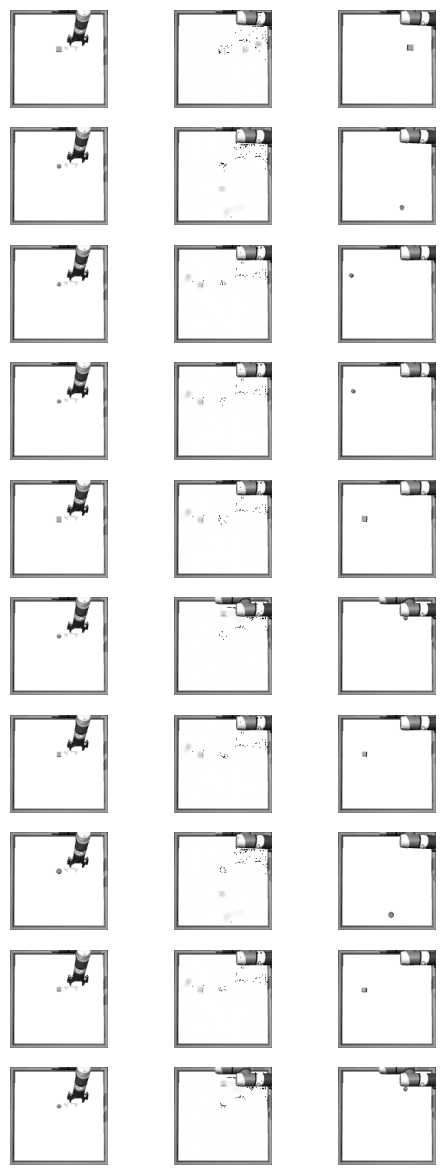

In [8]:
display_epoch(300)

mse: 0.0004854222643189132


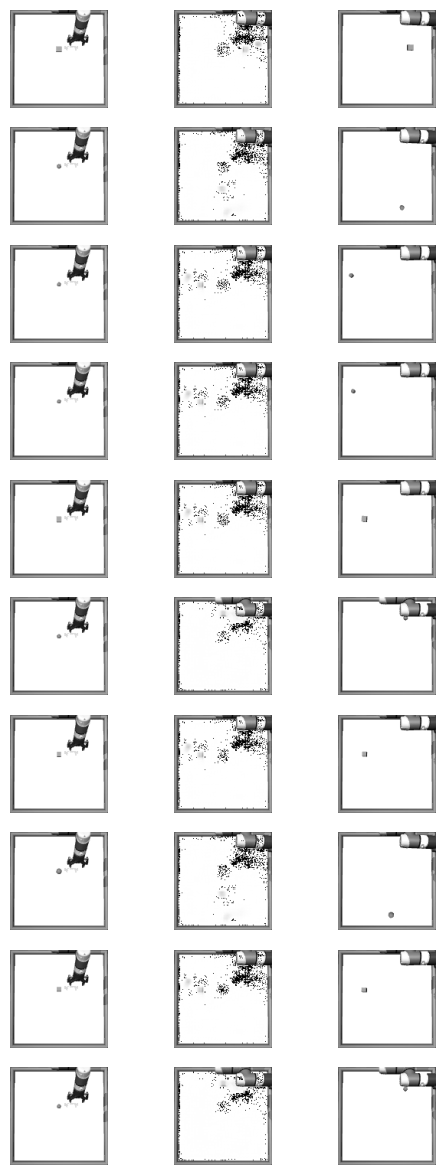

In [9]:
display_epoch(50)

mse: 0.00047751038800925016


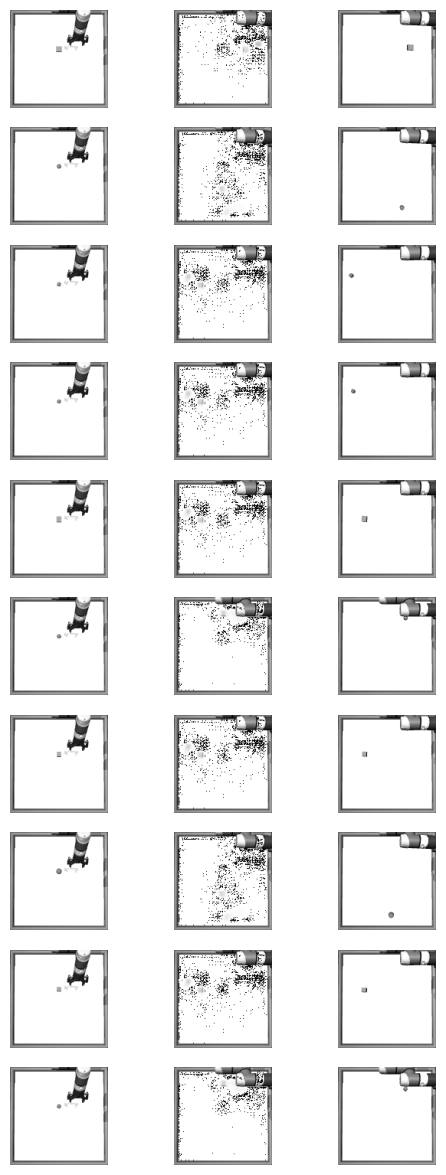

In [10]:
display_epoch(100)

mse: 0.00047672021901234984


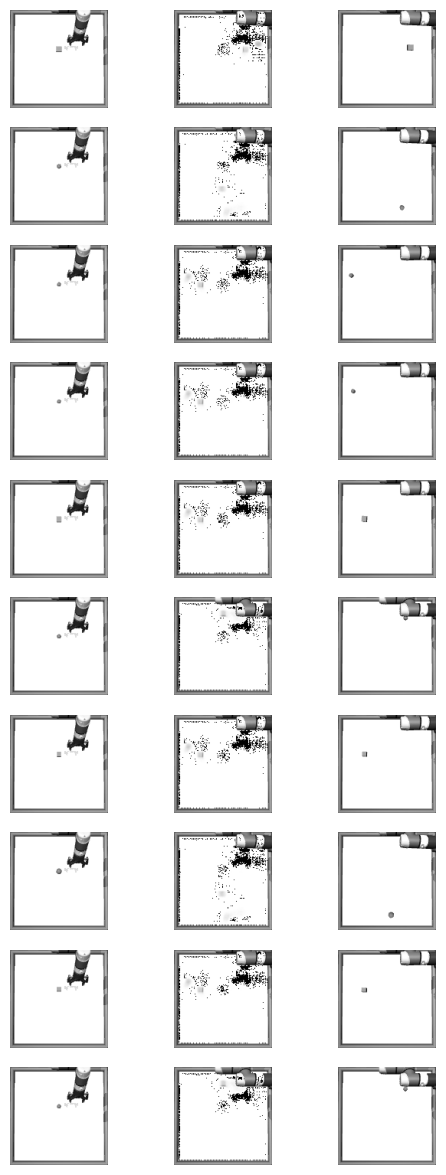

In [11]:
display_epoch(160)